In [1]:
import numpy as np
import pandas as pd
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import seaborn as sns


import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

# Part 1: Data Preparation

In [2]:
df_raw = pd.read_csv('data4.csv')

In [3]:
df_raw.head()

,datetime,choke,psig,apsig,oil,gas,water
0,15/5/2021 21:00:00,38.0,935.0,320.0,698.880,4.980,23.616
1,15/5/2021 21:15:00,38.0,935.0,321.0,822.456,4.988,32.592
2,15/5/2021 21:30:00,38.0,940.0,318.0,661.368,5.070,26.208
3,15/5/2021 21:45:00,38.0,938.0,317.0,737.664,5.061,29.232
4,15/5/2021 22:00:00,38.0,940.0,319.0,661.368,5.078,26.208


# Actual Chart

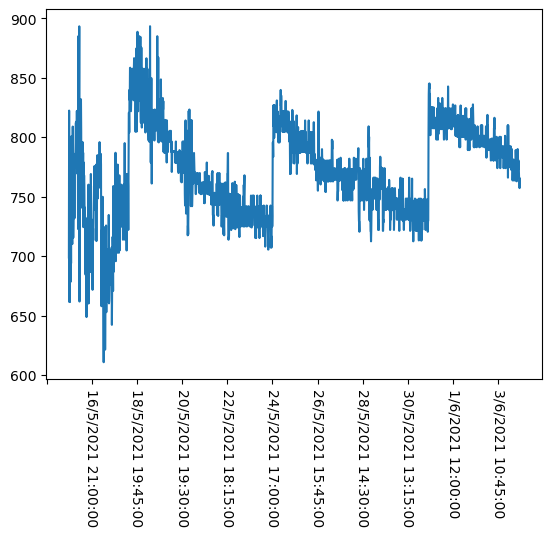

In [4]:
# sns.displot(df_raw[['datetime', 'oil']], kind='kde')
# sns.displot(df_raw[['datetime', 'gas']], kind='kde')
# sns.displot(df_raw[['datetime', 'water']], kind='kde')

# sns.displot(df_raw, kind='kde')

plt.plot(df_raw['datetime'], df_raw['oil'])
desired_ticks = 10
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=len(df_raw['datetime']) // desired_ticks))
plt.xticks(rotation=-90)
plt.show()

In [5]:
device = torch.device("cpu")
print(device)

cpu


In [6]:
df_raw_separated = df_raw[['datetime', 'oil', 'gas', 'water']].copy(deep=True)

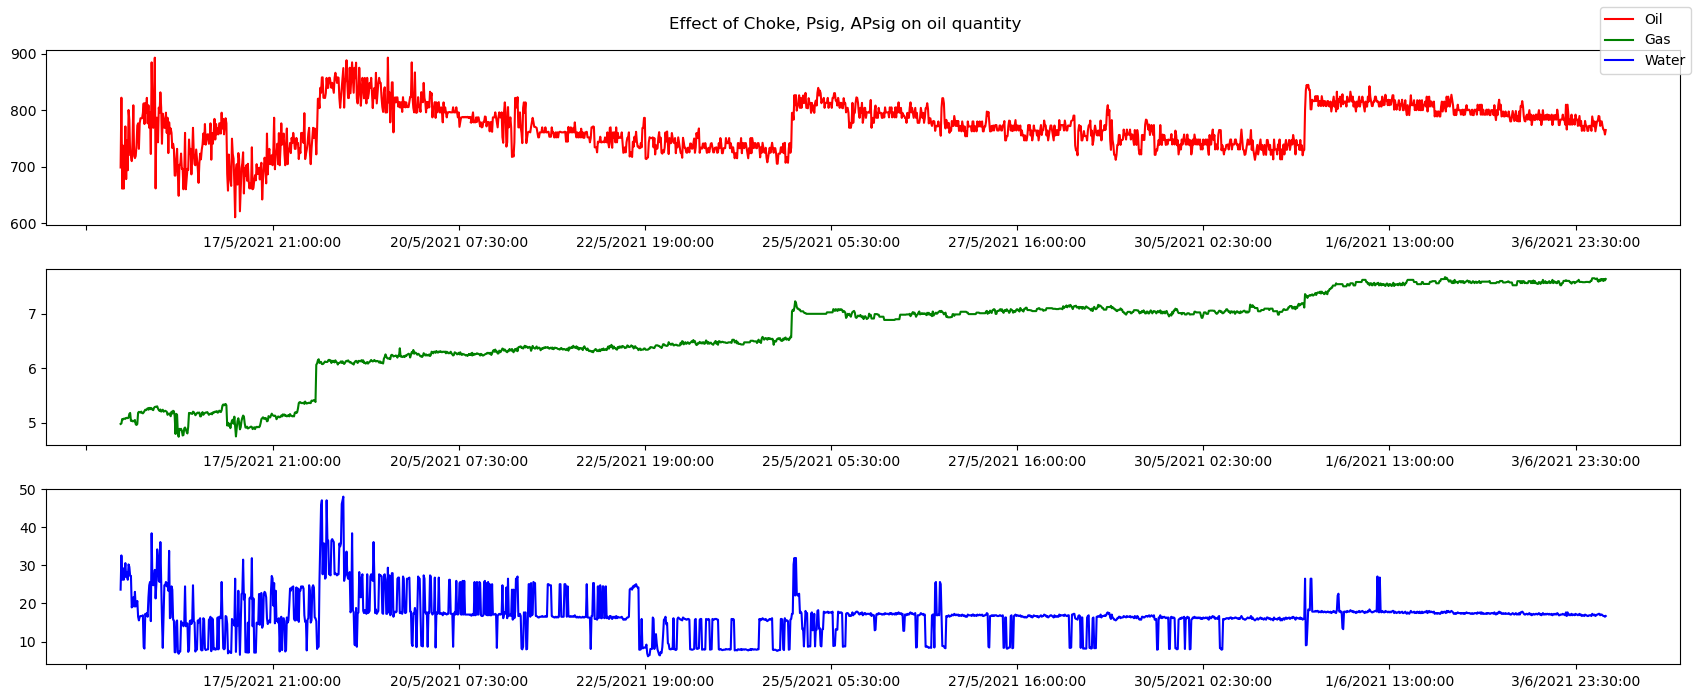

In [7]:
fig, ax = plt.subplots(figsize=(17,7), nrows=3)

desired_ticks = 8
for axis in ax:
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=len(df_raw_separated['datetime']) // desired_ticks))
    axis.tick_params(axis='x')


# Plotting on each subplot
ax[0].plot(df_raw_separated['datetime'], df_raw_separated['oil'], label='Oil', color='red')
ax[1].plot(df_raw_separated['datetime'], df_raw_separated['gas'], label='Gas', color='green')
ax[2].plot(df_raw_separated['datetime'], df_raw_separated['water'], label='Water', color='blue')

fig.suptitle('Effect of Choke, Psig, APsig on oil quantity')
fig.tight_layout()
fig.legend()
fig.show()

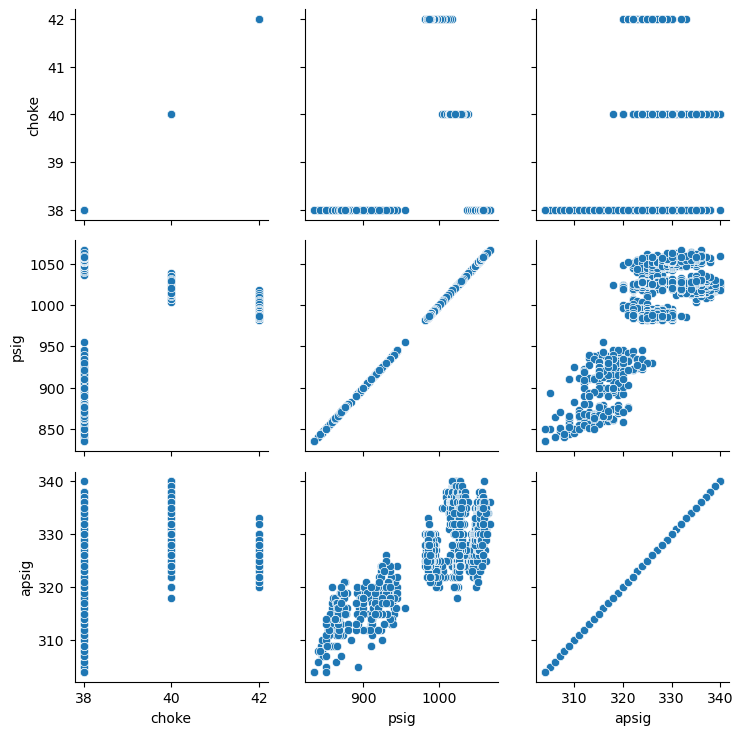

In [8]:
g = sns.PairGrid(df_raw[['choke', 'psig', 'apsig']])
g.map(sns.scatterplot)

# Part 2: Checking the Naive prediction's error
A naive oil/water/gas quantity prediction would be close to previous data. We will check the error term when we use this prediction and use it as the benchmark of our LSTM model.

In [9]:
df_naive_oil = df_raw[['datetime', 'oil']].copy(deep=True)
df_naive_oil['prev_oil'] = df_naive_oil['oil'].shift(1)
df_naive_oil.drop([0], inplace=True)
df_naive_oil['difference'] = df_naive_oil['oil'] - df_naive_oil['prev_oil']
df_naive_oil['square_error'] = df_naive_oil['difference'] ** 2
df_naive_oil.head()

,datetime,oil,prev_oil,difference,square_error
1,15/5/2021 21:15:00,822.456,698.880,123.576,15271.027776
2,15/5/2021 21:30:00,661.368,822.456,-161.088,25949.343744
3,15/5/2021 21:45:00,737.664,661.368,76.296,5821.079616
4,15/5/2021 22:00:00,661.368,737.664,-76.296,5821.079616
5,15/5/2021 22:15:00,712.248,661.368,50.880,2588.774400


In [10]:
square_error = df_naive_oil['square_error'].mean()
print(f'Square Error of the Naive Approach is {square_error:.3f}')

Square Error of the Naive Approach is 478.477


# Part 3: LSTM model for Oil/Water/Gas Quantity Prediction

In [11]:
df_raw.head()

,datetime,choke,psig,apsig,oil,gas,water
0,15/5/2021 21:00:00,38.0,935.0,320.0,698.880,4.980,23.616
1,15/5/2021 21:15:00,38.0,935.0,321.0,822.456,4.988,32.592
2,15/5/2021 21:30:00,38.0,940.0,318.0,661.368,5.070,26.208
3,15/5/2021 21:45:00,38.0,938.0,317.0,737.664,5.061,29.232
4,15/5/2021 22:00:00,38.0,940.0,319.0,661.368,5.078,26.208


In [12]:
df_LSTM = df_raw[['datetime', 'choke', 'psig', 'apsig', 'oil']].copy(deep=True)
df_LSTM.columns

Index(['datetime', 'choke', 'psig', 'apsig', 'oil'], dtype='object')

In [13]:
df_LSTM.head()

,datetime,choke,psig,apsig,oil
0,15/5/2021 21:00:00,38.0,935.0,320.0,698.880
1,15/5/2021 21:15:00,38.0,935.0,321.0,822.456
2,15/5/2021 21:30:00,38.0,940.0,318.0,661.368
3,15/5/2021 21:45:00,38.0,938.0,317.0,737.664
4,15/5/2021 22:00:00,38.0,940.0,319.0,661.368


In [14]:
input_data = df_LSTM.drop(['datetime'], axis=1)
targets = df_LSTM['oil'].values

We need to decide how many data rows' prior we need to see to predict today. Trial and error is a valid approach, but for this example I will be using 20 days as the target is not to get the best answer, just to check if LSTM is getting better predictions than the naive approach.

In [15]:
T = 20
D = input_data.shape[1]
N = len(input_data) - T
print(f'Dimensions are {T} x {D} x {N}')

Dimensions are 20 x 4 x 1858


In [16]:
#Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)
input_data
     

array([[-0.86113429, -1.40497653, -1.13850067, -1.68451336],
       [-0.86113429, -1.40497653, -1.00020025,  1.46185056],
       [-0.86113429, -1.31517206, -1.4151015 , -2.639605  ],
       ...,
       [ 2.94085485, -0.4889709 , -0.03209734,  0.00446506],
       [ 2.94085485, -0.45304911, -0.30869817, -0.19901895],
       [ 2.94085485, -0.47101   , -0.03209734,  0.00446506]])

In [17]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])


In [18]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])
     

In [19]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

#Using a classical LSTM structure

In [20]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out


For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 10,000 and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [21]:
model = LSTM(D, 512, 2, 1)
model.to(device)

LSTM(
  (rnn): LSTM(4, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

At training, Adam optimizer failed to converge for a long time (started to converge at around 800th epoch). SGD with 0.9 momentum worked well.

In [22]:
# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=200):

  # Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()

    if (epoch + 1) % 50 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')

  return train_losses, test_losses

In [23]:
train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=750)